## Load data

Fill in path to ConnectivityMatrix object below.

Also fill in path to output figure and the title to give it.

In [104]:
import numpy
import pandas

import conntility

from scipy.spatial import distance
from matplotlib import pyplot as plt


fn = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_out = "touch_count_probs_rat.pdf"
figure_title = "Rat: Structural"

M = conntility.ConnectivityMatrix.from_h5(fn)

## Parameters

In [86]:
max_touch_count = 10 # Plot up to that number of touches
dist_bin_sz = 50 # Size of distance bins in um
min_num_edges_last_bin = 5000 # For distance bins: How many edges must be in the last one at least? Determines distance cutoff

cols_xyz = ["x", "y", "z"] # Names of coordinates for distance calculation

## Calculations

In [53]:
# Add distance and distance bin information to the edges.
# The table of edges must contains columns "bin" (distance bin index) and "count" (number of touches). 

sum_deltas = numpy.zeros(len(M.edges))

for axis in cols_xyz:
    prop = M.edge_associated_vertex_properties(axis)
    delta = prop["row"].values - prop["col"].values
    sum_deltas += (delta ** 2)

M.add_edge_property("distance", numpy.sqrt(sum_deltas))

# Linear distance bins (for now)
tgt_percentile = 100 * (1.0 - min_num_edges_last_bin / len(M.edges)) # This way, the last distance bin will contain the specified number of edges.
max_dist = numpy.percentile(M.edges["distance"], tgt_percentile) # There are min_num_edges_last_bin edges beyond that distance!

dbins = numpy.arange(0, max_dist, dist_bin_sz)
dbins[0] = 1E-9
dbin_ids = numpy.arange(len(dbins))
bin_centers = dbins + 0.5 * numpy.mean(numpy.diff(dbins))
M.add_edge_property("bin", numpy.digitize(M.edges["distance"], bins=dbins) - 1)

print(M.edges["bin"].value_counts())

bin
4     10168897
3      9776778
5      9282939
6      7836165
2      7564209
7      6317404
8      4801208
1      3922957
9      3187926
10     1763615
11      914639
0       707487
12      463793
13      228714
14      109742
15       48225
16       18990
17       10330
Name: count, dtype: int64


In [54]:
master_table = M.edges.groupby("bin")["count"].value_counts().unstack("count", fill_value=0)
master_table

count,1,2,3,4,5,6,7,8,9,10,...,54,55,56,58,59,60,61,62,65,66
bin,,,,,,,,,,,,,,,,,,,,,
0,112404,103486,92444,79911,66238,54578,42957,34115,26893,20850,...,0,0,0,0,1,0,0,1,1,0
1,819923,673652,548757,435426,339338,263109,202033,153220,117514,88716,...,8,3,1,2,1,0,0,1,1,0
2,2240993,1545360,1097527,774762,548581,387080,274671,195075,138486,99558,...,4,1,2,3,1,1,1,0,1,0
3,3859541,2192251,1348118,839126,529614,339204,219713,144497,95218,64097,...,0,0,0,1,1,0,0,0,0,1
4,4886624,2306227,1244925,693289,398546,236839,144465,89425,56642,36164,...,0,1,0,0,0,0,0,0,0,0
5,5051856,2042390,1001092,515302,277352,156632,90302,54241,33071,20838,...,0,0,0,1,0,0,0,0,0,0
6,4593481,1657350,760266,371657,193764,105723,59993,35235,21223,13007,...,0,0,0,0,0,0,0,0,0,0
7,3860567,1288434,571668,271342,139823,76142,42810,24976,15013,9329,...,0,0,0,0,0,0,0,0,0,0
8,3025519,949175,410788,191867,96472,52512,29303,17079,10192,6248,...,0,0,0,0,0,0,0,0,0,0


In [55]:
D = distance.squareform(distance.pdist(M.vertices[cols_xyz]))
D = numpy.digitize(D.flatten(), bins=dbins) - 1
Dcounts = pandas.Series(D, name="bin").value_counts().drop(-1)

master_table[0] = Dcounts - master_table.sum(axis=1) # Zero touches pair count
master_table = master_table.sort_index(axis=1, ascending=False)

In [44]:
P = master_table.cumsum(axis=1).values[:, :-1] / master_table.values[:, 1:]
P = pandas.DataFrame(P, columns=master_table.columns[:-1], index=master_table.index)

/nvme/reimann/2632041/ipykernel_29531/3201694816.py:1: RuntimeWarning: divide by zero encountered in divide
  P = master_table.cumsum(axis=1).values[:, :-1] / master_table.values[:, 1:]
/nvme/reimann/2632041/ipykernel_29531/3201694816.py:1: RuntimeWarning: invalid value encountered in divide
  P = master_table.cumsum(axis=1).values[:, :-1] / master_table.values[:, 1:]


In [79]:
P_geq = master_table.cumsum(axis=1)
P_gt = P_geq.copy()
P_gt.columns = P_gt.columns - 1

condP = P_gt.div(P_geq, fill_value=0).drop(columns=-1)
condP.columns = condP.columns + 1

## Plotting

In [84]:
touches

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

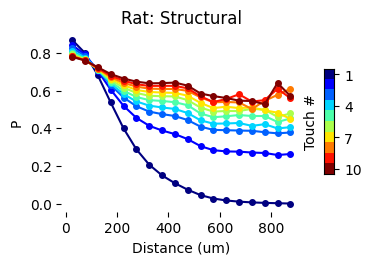

In [106]:
from matplotlib import cm

cmap = cm.jet

touches = numpy.arange(1, max_touch_count + 1)
touch_col_v = numpy.linspace(0, 1, len(touches))

fig = plt.figure(figsize=(3, 2))
ax = fig.add_axes([0.05, 0.05, 0.8, 0.9])

for t, v in zip(touches, touch_col_v):
    col = cmap(v)
    ax.plot(bin_centers, condP[t], color=col, label="Touch #{0}".format(t), marker='o', ms=4)

ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
ax.set_title(figure_title)

ax = fig.add_axes([0.925, 0.15, 0.035, 0.7])
ax.imshow(cmap(touch_col_v).reshape((-1, 1, 4)))
ax.yaxis.tick_right()
ax.set_xticks([])
ax.set_yticks(numpy.arange(1, max_touch_count + 1, 3) - 1)
ax.set_yticklabels(numpy.arange(1, max_touch_count + 1, 3))
ax.set_ylabel("Touch #")

fig.savefig(fn_out)